In [1]:
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, SystemMessage
from typing import TypedDict, Optional, Annotated
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition



from langchain.tools import tool
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.document_loaders import PyPDFLoader





from youtube_transcript_api import YouTubeTranscriptApi
from dotenv import load_dotenv


import operator
import json



In [2]:
load_dotenv()

True

In [3]:
class Store:
    vector_store: Optional[FAISS] = None


In [4]:
llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")
embeddings = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")

In [5]:

def store_the_video_transcript_in_vector_store(video_id: str):
    """Get the transcript of the video  and then splits it into documents and then stores the embeddings in the vector store"""

    global vector_store
    transcript_list = YouTubeTranscriptApi().fetch(video_id, languages=["en"])
    full_transcript = " ".join([segment.text for segment in transcript_list])

    text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )

    docs = text_splitter.create_documents([full_transcript])
    Store.vector_store = FAISS.from_documents(
        documents=docs,
        embedding=embeddings
    )

In [6]:
def store_the_pdf_embedding(pdf_path) :
    """
        Load PDF, create embeddings, store FAISS on disk
    """
     
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()


    if not documents:
        raise ValueError("PDF is empty or unreadable")
    
    print("Pages loaded:", len(documents))
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )

    splits = splitter.split_documents(documents)

    splits = [d for d in splits if d.page_content.strip()]

    if not splits:
        raise ValueError("No usable text found")

    print("Chunks created:", len(splits))

    # Create FAISS
    Store.vector_store = FAISS.from_documents(
        splits,
        embeddings
    )

    

In [7]:
@tool
def search_pdf(query: str):
    """
        Search the uploaded PDF document for relevant information.
       Use this when the user asks questions about the PDF content.
       The query can be general also 
    """

    print(f"pdf came finally 1{query}") 

    if Store.vector_store is None:
        return "No pdf uploaded yet. Please upload the pdf first"
    
    print(f"pdf came finally {query}") 
    
    retriever = Store.vector_store.as_retriever(search_type = 'similarity' ,search_kwargs = {'k' : 4})

    result = retriever.invoke(query)
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query' : query,
        'context': context,
        'metadata': metadata
    }

In [8]:
@tool
def  get_the_video_query(query: str):
    """ 
        Answer questions about the currently loaded YouTube video transcript.

        Use this tool whenever the user asks anything about the video.
        Pass the user's full question as `query`.
    """

    if Store.vector_store is None:
        return "No video id provided"
    
    print(f"came finally {query}")  # DEBUG

    
    retriever = Store.vector_store.as_retriever(search_type = 'similarity' ,search_kwargs = {'k' : 4})
    result = retriever.invoke(query)
    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    print(f"came finally context{context}")  # DEBUG

    return {
        'query' : query,
        'context': context,
        'metadata': metadata
    }

In [9]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage] , operator.add]

In [10]:
search = DuckDuckGoSearchRun()


In [11]:
tools = [get_the_video_query, search_pdf]

In [12]:
llm_with_tools = llm.bind_tools(tools)


In [13]:
named_tools = {}
for tool in tools:
    if hasattr(tool, "name"):
        named_tools[tool.name] = tool
    else:
        named_tools[tool.__name__] = tool    

In [14]:
for name, tool in named_tools.items():
    print("name:", name)
    print("tool:", tool)

name: get_the_video_query
tool: name='get_the_video_query' description="Answer questions about the currently loaded YouTube video transcript.\n\nUse this tool whenever the user asks anything about the video.\nPass the user's full question as `query`." args_schema=<class 'langchain_core.utils.pydantic.get_the_video_query'> func=<function get_the_video_query at 0x7ff272fc74c0>
name: search_pdf
tool: name='search_pdf' description='Search the uploaded PDF document for relevant information.\nUse this when the user asks questions about the PDF content.\nThe query can be general also' args_schema=<class 'langchain_core.utils.pydantic.search_pdf'> func=<function search_pdf at 0x7ff272fc7420>


In [15]:
async  def llm_tool_call(state: ChatState):
    ai_message = state["messages"][-1]

    tool_messages = []

    for tc in ai_message.tool_calls:
        tool_name = tc["name"]
        tool_args = tc.get("args", {}) or {}
        tool_call_id = tc.get("id", tool_name)
        print(f"Calling tool: {tool_name} with args: {tool_args}")  # DEBUG


        tool = named_tools.get(tool_name)
        if tool is None:
            raise ValueError(f"Tool '{tool_name}' not found")

        if hasattr(tool, "ainvoke"):
            result = await tool.ainvoke(tool_args)
        else:
            result = tool(**tool_args)

        tool_messages.append(
            ToolMessage(
                content=json.dumps(result),
                tool_call_id=tool_call_id,
            )
        )

    return {"messages": tool_messages}

In [16]:
def chat_node(state :ChatState):
    """
        llm node that may answer or request a tool call
    """

    messages = state['messages']
    response = llm_with_tools.invoke(messages,timeout=15)
    return {'messages' : [response]}

tool_nodes = ToolNode(tools)


In [17]:
def condition(state: ChatState):
    last_msg = state["messages"][-1]

    if not getattr(last_msg, "tool_calls", None):
        return "end"

    return "calling_tool"

In [18]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("llm_tool_call", llm_tool_call)

graph.add_edge(START, "chat_node")

graph.add_conditional_edges(
    "chat_node",
    condition,
    {
        "end": END,
        "calling_tool": "llm_tool_call",
    }
)

graph.add_edge("llm_tool_call", "chat_node")
checkpointer = InMemorySaver()
chatbot = graph.compile(checkpointer = checkpointer)

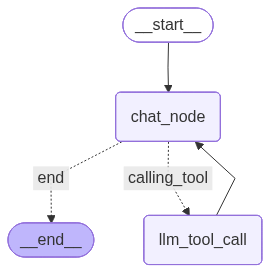

In [19]:
chatbot

In [20]:
# store_the_video_transcript_in_vector_store("O1z_-O6IXIc")

In [21]:
store_the_pdf_embedding("/home/dhruv-tiwari/node/gfg/testing_pdf.pdf")

Pages loaded: 41
Chunks created: 38


In [22]:
Store.vector_store

In [23]:
print("Type 'exit' to quit.\n")

while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit"]:
        print("Bye 👋")
        break

    response = await chatbot.ainvoke(
        {   

            "messages": [
                SystemMessage(
                    content=(
                        "You are allowed to answer general knowledge questions directly. "
                        "Only call tools if they are actually required. "
                        "If no tool applies, answer normally."
                    )
                ),
                HumanMessage(content=user_input)
            ]
        },
        config={
            "configurable": {
                "thread_id": 2
            }
        }
    )

    print("AI:", response["messages"][-1].content)
    print("-" * 50)

Type 'exit' to quit.

AI: Hello! I'm here to help you with your YouTube video and PDF document. Please tell me what you'd like to know!
--------------------------------------------------
Calling tool: search_pdf with args: {'query': 'what is given in the provided pdf'}
pdf came finally 1what is given in the provided pdf
pdf came finally what is given in the provided pdf
AI: [{'type': 'text', 'text': 'The provided PDF discusses Semi-Supervised Learning, including the objective function for the discriminator and the assumptions under which semi-supervised learning can work. It also illustrates how smoothness and low-density assumptions can lead to more intuitive decision boundaries compared to supervised methods with limited labeled data.', 'extras': {'signature': 'CvwEAb4+9vtYtHTNxz+eIj4wytiPmYIzDxPGFp5LdUYVZE4JxfMNK9Z/9eDBTd/d4Mid0y83V7Ghxqy6Luvh1GExfLkmQeIcE0on2fz/FuS0Ii47VqDUTc5whKlbL2CCPCl09ogIw10IFX0m1T/FbI/fkDgUwxZoTKigPgC/UUtm2kV49LCGMlfuwvhAdQOKt0ybYgOAunUtkdoGBMehMEqxzrYshaolPv